## 03 - Modelling and Evaluating

### Objective

Answer Business Requirement 2:

- The client is interested to predict whether a cherry leaf is healthy or contains powdery mildew.

### Inputs

- inputs/cherry_leaves_split/train
- inputs/cherry_leaves_split/val
- inputs/cherry_leaves_split/test
- outputs/02_data_visualisation/image_shape.pkl

### Outputs

- Model saved as .h5
- Class indices saved as .pkl
- Learning curves
- Model evaluation score

### Imports

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

sns.set_style("whitegrid")

### Set Working Directory

In [8]:
os.chdir('/workspaces/cherry-leaves-health')
print("Current directory:", os.getcwd())

Current directory: /workspaces/cherry-leaves-health


### Set paths

In [9]:
cwd = os.getcwd()
print("Working directory set:", cwd)

train_path = "/workspaces/cherry-leaves-health/inputs/cherry_leaves_split/train"
val_path = "/workspaces/cherry-leaves-health/inputs/cherry_leaves_split/val"
test_path = "/workspaces/cherry-leaves-health/inputs/cherry_leaves_split/test"

version = "03_modelling_and_evaluating"
file_path = f"outputs/{version}"
os.makedirs(file_path, exist_ok=True)

Working directory set: /workspaces/cherry-leaves-health


### Labels and image shape

In [10]:
labels = os.listdir(train_path)
print("Project Labels:", labels)

image_shape = joblib.load("outputs/02_data_visualisation/image_shape.pkl")
print("Image shape:", image_shape)

Project Labels: ['healthy', 'powdery_mildew']
Image shape: (256, 256, 3)


### Image count distribution

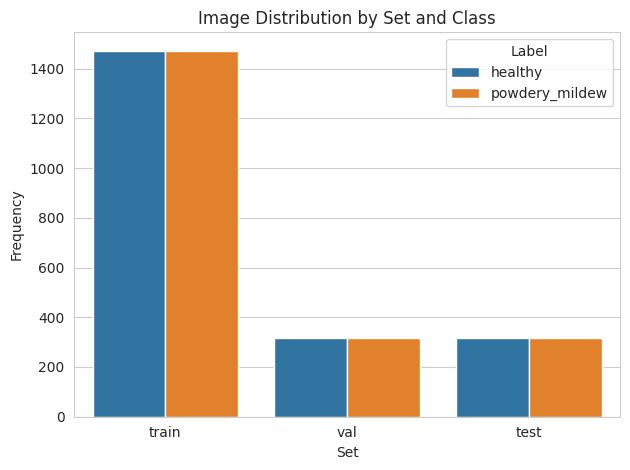

In [11]:
df_freq = pd.DataFrame()
for folder in ['train', 'val', 'test']:
    for label in labels:
        count = len(os.listdir(f"inputs/cherry_leaves_split/{folder}/{label}"))
        df_freq = pd.concat([df_freq, pd.DataFrame([{"Set": folder, "Label": label, "Frequency": count}])])

sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Image Distribution by Set and Class")
plt.tight_layout()
plt.savefig(f"{file_path}/labels_distribution.png", dpi=150)
plt.show()

### Image Augmentation

In [12]:
batch_size = 20

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(train_path, target_size=image_shape[:2], batch_size=batch_size, class_mode='binary')
val_set = val_test_datagen.flow_from_directory(val_path, target_size=image_shape[:2], batch_size=batch_size, class_mode='binary')
test_set = val_test_datagen.flow_from_directory(test_path, target_size=image_shape[:2], batch_size=batch_size, class_mode='binary')

Found 2944 images belonging to 2 classes.
Found 630 images belonging to 2 classes.
Found 634 images belonging to 2 classes.


### Preview augmented images

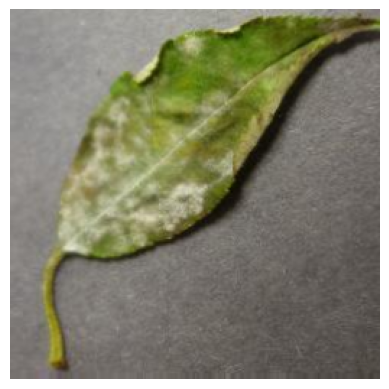

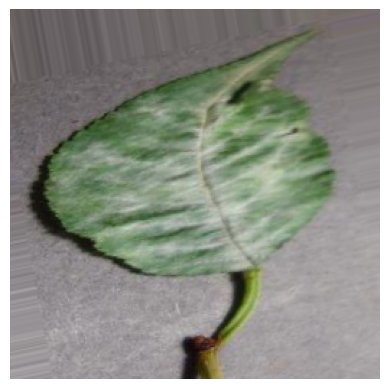

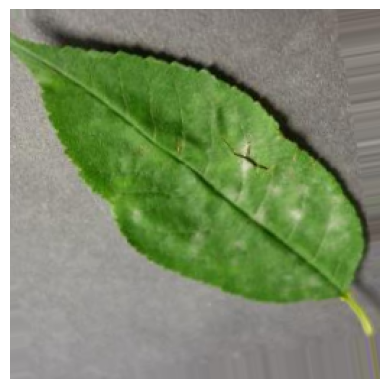

In [13]:
for _ in range(3):
    img, label = next(train_set)
    plt.imshow(img[0])
    plt.axis("off")
    plt.show()

### Save class indices

In [21]:
import os
import joblib

# Make sure the directory exists
os.makedirs(file_path, exist_ok=True)

# Save to the correct path
joblib.dump(train_set.class_indices, f"{file_path}/class_indices.pkl")


['outputs/03_modelling_and_evaluating/class_indices.pkl']

### Create CNN Model

In [9]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=image_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,429,377 (28.34 MB)

 Trainable params: 7,429,377 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_set,
    epochs=25,
    steps_per_epoch=len(train_set),
    validation_data=val_set,
    validation_steps=len(val_set),
    callbacks=[early_stop],
    verbose=1
)

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 122s 811ms/step - accuracy: 0.7072 - loss: 0.5557 - val_accuracy: 0.8270 - val_loss: 0.3132
Epoch 2/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 139s 791ms/step - accuracy: 0.9463 - loss: 0.1576 - val_accuracy: 1.0000 - val_loss: 0.0090
Epoch 3/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 118s 798ms/step - accuracy: 0.9889 - loss: 0.0485 - val_accuracy: 0.9968 - val_loss: 0.0092
Epoch 4/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 118s 795ms/step - accuracy: 0.9751 - loss: 0.0700 - val_accuracy: 0.9984 - val_loss: 0.0032
Epoch 5/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 118s 796ms/step - accuracy: 0.9776 - loss: 0.0550 - val_accuracy: 1.0000 - val_loss: 9.5657e-04
Epoch 6/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 142s 799ms/step - accuracy: 0.9970 - loss: 0.0183 - val_accuracy: 1.0000 - val_loss: 6.4580e-04
Epoch 7/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 119s 804ms/step - accuracy: 0.9874 - loss: 0.0508 - val_accuracy: 1.0000 - val_loss: 7.5626e-04
Epoch 8/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 143s 808ms/step - accura

### Save the model

In [11]:
model.save("/workspaces/cherry-leaves-health/jupyter_notebooks/outputs/v1/cherry_leaf_mildew_model.h5")

### Learning Curves

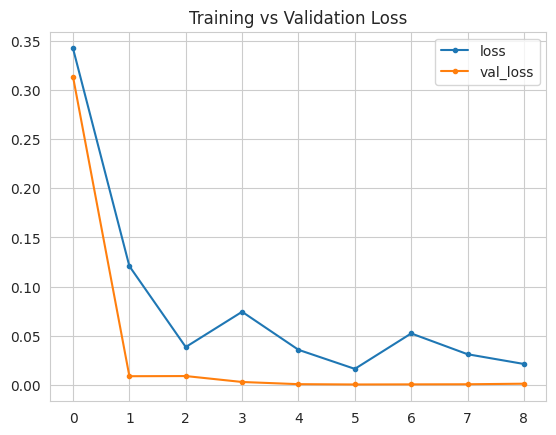

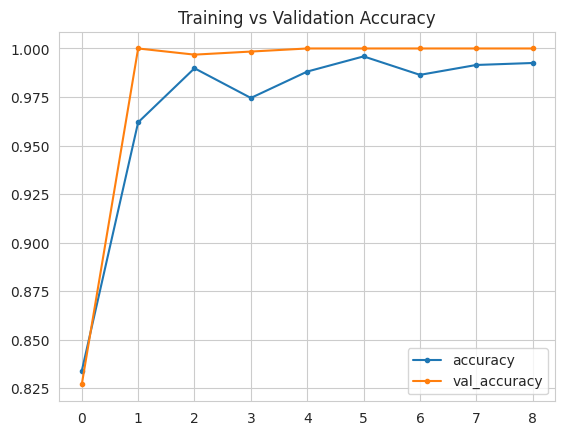

In [12]:
loss_df = pd.DataFrame(history.history)

loss_df[['loss', 'val_loss']].plot(style='.-')
plt.title("Training vs Validation Loss")
plt.savefig(f"{file_path}/training_loss.png", dpi=150)
plt.show()

loss_df[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Training vs Validation Accuracy")
plt.savefig(f"{file_path}/training_accuracy.png", dpi=150)
plt.show()

### Evaluate on Test Set

In [13]:
K.clear_session()  # Clear previous model traces
model = load_model("/workspaces/cherry-leaves-health/jupyter_notebooks/outputs/v1/cherry_leaf_mildew_model.h5")

test_eval = model.evaluate(test_set)
print("Test Set Evaluation (Loss, Accuracy):", test_eval)

joblib.dump(test_eval, "/workspaces/cherry-leaves-health/jupyter_notebooks/outputs/v1/evaluation.pkl")

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 1.0000 - loss: 6.7122e-04
Test Set Evaluation (Loss, Accuracy): [0.00039026050944812596, 1.0]


['/workspaces/cherry-leaves-health/jupyter_notebooks/outputs/v1/evaluation.pkl']

### Predict on a random image

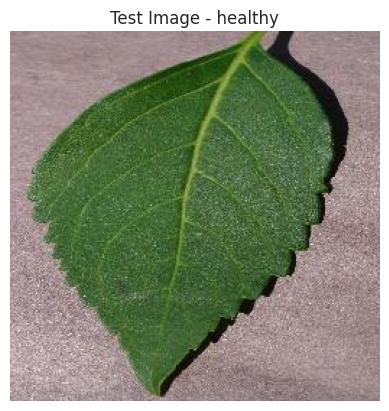

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicted: healthy (1.00 confidence)


In [14]:
def predict_image(model, image_path, class_map):
    img = load_img(image_path, target_size=image_shape[:2])
    arr = img_to_array(img) / 255.
    arr = np.expand_dims(arr, axis=0)
    prob = model.predict(arr)[0, 0]
    pred_class = class_map[int(prob > 0.5)]
    confidence = prob if pred_class == class_map[1] else 1 - prob
    return pred_class, confidence

pointer = 10
label = labels[0]
img_file = os.listdir(f"{test_path}/{label}")[pointer]
img_path = os.path.join(test_path, label, img_file)

plt.imshow(load_img(img_path))
plt.axis("off")
plt.title(f"Test Image - {label}")
plt.show()

class_map = {v: k for k, v in train_set.class_indices.items()}
pred, conf = predict_image(model, img_path, class_map)
print(f"Predicted: {pred} ({conf:.2f} confidence)")

### Push files to repo